In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip install pillow==4.0.0

import torch
import torch.nn as nn

from torch.nn import ReLU as relu
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
# New imports
from torch.nn.parameter import Parameter
import pdb 
 
assert torch.cuda.is_available()

import torchvision
import os
import gzip
import tarfile
import gc

    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61ab2000 @  0x7fcadaf282a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
from PIL import Image
import io
 
from google.colab import files
 
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
 
print('Upload Content Image')
file_dict = files.upload()
content_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0)
 
print('\nUpload Style Image')
file_dict = files.upload()
style_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0)

Upload Content Image


Saving content.png to content.png

Upload Style Image


Saving IMG_1352.JPG to IMG_1352.JPG


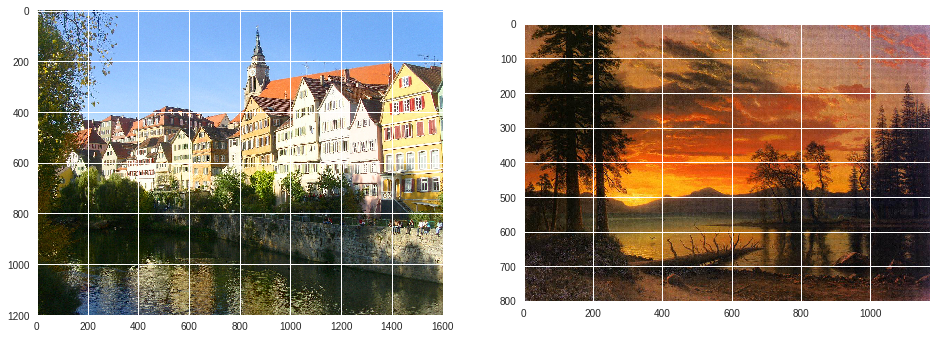

In [0]:
plt.figure(figsize = (16,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
style_image = Image.open("IMG_1352.JPG")
content_image = Image.open("content.png")
ax1.imshow(content_image)



ax2.imshow(style_image)
content_image,style_image = load_and_normalize(np.array(content_image)).unsqueeze(0),load_and_normalize(np.array(style_image)).unsqueeze(0)

In [0]:
import torchvision.models as models
import PIL
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 64841864.19it/s]


In [0]:
alpha = 1
beta = 1000

class Image_class:
    def __init__(self, img):
        self.img = torch.tensor(img, requires_grad=True, device='cuda')
        
    def show(self):
        X = self.img - self.img.min()
        X = X/X.max()

        X = np.array(X.detach().squeeze(0))

        for i in range(X.shape[0]):
            X[i] = X[i].T
        X = X.T
        X = (X*255.9999).astype(np.uint8)
        return PIL.Image.fromarray(X).resize(500,500)

class VGGIntermediate(nn.Module):
    def __init__(self, requested=[]):
        super(VGGIntermediate, self).__init__()

        self.intermediates = {}
        self.vgg = models.vgg16(pretrained=True).features.eval()
        for i, m in enumerate(self.vgg.children()):
            if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
                m.inplace = False          # the model has a hard time going backwards on the in place functions. 

            if i in requested:
                def curry(i):
                    def hook(module, input, output):
                        self.intermediates[i] = output
                    return hook
                m.register_forward_hook(curry(i))

    def forward(self, x):
        self.vgg(x)  
    
        return self.intermediates
    
class ContentLoss(nn.Module):
    def __init__(self, P):
        super(ContentLoss, self).__init__()
        
        a,b,c,d = P.size()
        P = P.reshape(a*b,c*d)
        self.P = P.cuda() # original image
        
    def forward(self, F): # loss for content
        a,b,c,d = F.size()
        F = F.reshape(a*b,c*d)
        return 1/2*torch.sum((F - self.P)**2)
    
class StyleLoss(nn.Module):
    def __init__(self, A):
        super(StyleLoss, self).__init__()
        self.A = [gramm_matrix(i.cuda()) for i in A]
        
    def forward(self, x):
        B = [gramm_matrix(k) for k in x]
        es = [1/(4*i[1]*j[1])*torch.sum((i[0]-j[0])**2) for i,j in zip(self.A, B)]
        return sum(es)
    

class LossTotal(nn.Module):
    def __init__(self, cl, sl):
        super(LossTotal, self).__init__()
        self.con = cl
        self.sty = sl
        
    def forward(self, x, y):
        return alpha*self.con.forward(x) + beta*self.sty.forward(y)

def gramm_matrix(Q):
    a,b,c,d = Q.size()
    da_matrix = Q.reshape(a*b,c*d)
    G = torch.mm(da_matrix, da_matrix.transpose(0,1))
    return [G, a*b*c*d]

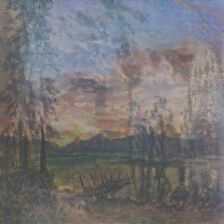

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", 
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

requested_vals = [vgg_names.index("conv4_2"),
                 vgg_names.index("conv1_1"),
                 vgg_names.index("conv2_1"),
                 vgg_names.index("conv3_1"),
                 vgg_names.index("conv4_1"),
                 vgg_names.index("conv5_1")]

model = VGGIntermediate(requested=requested_vals)
model.cuda()
    
losses = []
validations = []
accuracy = []
val_losses = []

train_image = Image_class(content_image)
content_layers = model(content_image.cuda()) # content stats
style_layers = model(style_image.cuda()) # style stats

ConLoss = ContentLoss(content_layers[vgg_names.index("conv4_2")])
StyLoss = StyleLoss([style_layers[j] for j in requested_vals[1:]])

train_image = Image_class(content_image)

def scope():
    gc.collect()

    objective = LossTotal(ConLoss, StyLoss)
    optimizer = optim.Adam([train_image.img], lr= 0.1)

    loop = tqdm(total=1000, position=0, leave=False)
    
    for i in range(1000):

        optimizer.zero_grad()
        layers = model(train_image.img.cuda())
        y_con = layers[vgg_names.index("conv4_2")]
        y_sty = [layers[j] for j in requested_vals[1:]]
        loss = objective(y_con, y_sty)
        loss.backward(retain_graph = True)
        

        losses.append(loss.item())

        loop.set_description('loss: {:.4f}'.format(loss.item()))
        loop.update(1)


        optimizer.step()
    loop.close()
scope()
train_image.show()

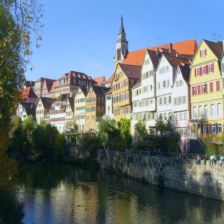

In [0]:
train_image.show()
ahhh = Image_class(content_image)
ahhh.show()